In [1]:
import re
from string import punctuation
from collections import defaultdict, Counter
from tqdm import tqdm

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import TfidfModel
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.9/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
lemmatizer = WordNetLemmatizer()
english_stopwords = stopwords.words('english') + ["I'm", "n't"]

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text: str) -> str:
    if text is None:
        return []
    
    text = re.sub('\s+', ' ', text) # удаляем табуляцию
    text = re.sub('(```[^`]*```)+', '', text) #удаляем код
    text = text.replace('\"', '')
    text = text.replace('+', '')
    text = text.replace('-', '')
    text = text.replace('~', '')
    text = text.replace('`', '')

    tokens = nltk.word_tokenize(text.lower())

    filtered_tokens = []
    for token in tokens:
        token = token.strip()
        token = lemmatizer.lemmatize(token, get_wordnet_pos(token))
        if token != ' ' and token not in english_stopwords and token not in punctuation:
            filtered_tokens.append(token)

    return filtered_tokens

In [3]:
def get_pmi_matrix(text, window_size=5, min_df=5, max_df=1200, alpha=0.75):
    window_half_size = window_size // 2
    word_counter = Counter()

    for sentence in tqdm(text, "sentences, pre-fit"):
        for word in sentence:
            word_counter[word] += 1

    for_exclusion = set()

    for key, value in word_counter.items():
        if value < min_df or value > max_df:
            for_exclusion.add(key)

    word_context_matrix = defaultdict(lambda: 0)
    word_counts = defaultdict(lambda: 0)

    for sentence in tqdm(text, "sentences", len(text)):
        # проходим центром окна по предложению
        for w_i in range(len(sentence)):
            word = sentence[w_i]
            if word in for_exclusion:
                continue

            left_bound = max(w_i - window_half_size, 0)
            right_bound = min(w_i + window_half_size + 1, len(sentence))
            for c_i in range(left_bound, right_bound):
                context = sentence[c_i]
                if c_i != w_i and context not in for_exclusion:
                    word_counts[word] += 1
                    word_context_matrix[(word, context)] += 1

    for (w, c) in word_context_matrix.keys():
        assert word_context_matrix[(w, c)] == word_context_matrix[(c, w)], 'not symmetric matrix'

    alpha_total_counts = 0
    for word_count in word_counts.values():
        alpha_total_counts += word_count ** alpha

    for (w, c), v in word_context_matrix.items():
        pmi = np.log(alpha_total_counts * v / word_counts[w] / word_counts[c] ** alpha)
        ppmi = max(0, pmi)
        word_context_matrix[(w, c)] = ppmi
    
    return word_context_matrix

In [20]:
class Lda:
    def __init__(self, text, num_topics=10):
        self.num_topics = num_topics

        self.dictionary = Dictionary(text)
        self.dictionary.filter_n_most_frequent(10)
        self.dictionary.filter_extremes()

        corpus = [self.dictionary.doc2bow(t) for t in text]
        self.tf_idf = TfidfModel(corpus, id2word=self.dictionary)
        self.corpus = self.tf_idf[corpus]

        self.model = LdaModel(self.corpus, num_topics, id2word=self.dictionary, random_state=42)
    
    def change_num_topics(self, num_topics):
        self.num_topics = num_topics
        self.model = LdaModel(self.corpus, num_topics, id2word=self.dictionary, random_state=42)

    # Когерентность тематики — средняя PMI для top k слов тематики
    def get_my_coherence(self, pmi_matrix, k=10):
        pmi_t_array = []
        for t in range(self.num_topics):
            pmi_t = 0
            topic_top_k_words = self.get_top_k_words_of_topic(t, k)
            for i in range(k - 1):
                for j in range(i + 1, k):
                    w_i = topic_top_k_words[i]
                    w_j = topic_top_k_words[j]
                    pmi_t += pmi_matrix[(w_i, w_j)]
            pmi_t_array.append(2 * pmi_t / (k * (k + 1)))
        return np.mean(pmi_t_array)

    def get_top_k_words_of_topic(self, t, k=10):
        return [pair[0] for pair in self.model.show_topic(t, k)]
    
    def get_top_k_words_of_topics(self, k=10):
        for t in range(model.num_topics):
            topic_top_k_words = model.get_top_k_words_of_topic(t, k)
            print(f"Topic: {t} \nWords: {topic_top_k_words}")
            
    def topics_visualization(self):
        return pyLDAvis.gensim_models.prepare(self.model, self.corpus, self.dictionary, mds="mmds")
    
    def proba_predict(self, text):
        dictionary = Dictionary(text)
        dictionary.filter_n_most_frequent(10)
        dictionary.filter_extremes()

        corpus = [dictionary.doc2bow(t) for t in text]
        corpus = self.tf_idf[corpus]
        
        return list(self.model.get_document_topics(corpus))

    def predict(self, text):
        proba_prediction = self.proba_predict(text)
        prediction_topics = []
        for topics_probs in proba_prediction:
            probs = [pairs[1] for pairs in topics_probs]
            index = np.argmax(probs)
            topic = topics_probs[index][0]
            prediction_topics.append(topic)
        return prediction_topics
    
    def predict_topics_visualization(self, text):
        dictionary = Dictionary(text)
        dictionary.filter_n_most_frequent(10)
        dictionary.filter_extremes()

        corpus = [dictionary.doc2bow(t) for t in text]
        corpus = self.tf_idf[corpus]
        return pyLDAvis.gensim_models.prepare(self.model, corpus, self.dictionary, mds="mmds")

In [5]:
def my_coherence(text, num_topics_array, window_size=5, k=10):
    pmi_matrix = get_pmi_matrix(text, window_size)

    model = Lda(text)
    
    coherence_array = []
    for num_topics in tqdm(num_topics_array):
        model.change_num_topics(num_topics)
        coherence_array.append(model.get_my_coherence(pmi_matrix, k))
        
    return coherence_array

In [6]:
def coherence(text, num_topics_array, window_size=5, k=10):
    model = Lda(text)
    coherence_array = []
    for num_topics in tqdm(num_topics_array):
        model.change_num_topics(num_topics)
        cm = CoherenceModel(model.model, texts=text, window_size=window_size, coherence="c_uci", topn=k)
        coherence_array.append(cm.get_coherence())
        
    return coherence_array

# Предварительная обработка данных

In [7]:
data = pd.read_json('pycharm_issues.json',  lines=True)

In [8]:
data.head()

,idReadable,created,summary,description,Affected versions
0,PY-22135,1483471995465,"""Parameter foo unfilled"": false positives for ...","I'm getting false ""Incorrect call argument"" in...",[2016.3]
1,PY-22143,1483528763930,Python Extract Superclass: Incorrect Order of ...,"When extracting superclasses, if extractions i...",[2016.3]
2,PY-22145,1483545972098,Inspection does not report 'Unresolved Referen...,If a variable is deleted using the `del` state...,[2016.2]
3,PY-22149,1483572086024,ipython notebook clear_output() not working,"Below code should print only once ""Hellow Worl...",[]
4,PY-22128,1483387969625,False negative: no error for round brackets in...,I believe it's rather a common typo to use rou...,[2017.1]


In [9]:
versions = np.hstack(data['Affected versions'])
versions.sort()

unique_version = np.unique(versions)
last_five = unique_version[-5:]
mask = data['Affected versions'].apply(lambda x: len(np.intersect1d(x, last_five)) > 0)
res_data = data[mask]
res_data.reset_index(inplace=True, drop=True)

In [10]:
res_data.head()

,idReadable,created,summary,description,Affected versions
0,PY-22211,1484097590051,Running subprocesses with Popen inside unittes...,I have the following unittest:\n\n```\nclass M...,[2020.3]
1,PY-22248,1484322653638,Full project optimize imports alters library f...,Reported by: @matheusbrat on Twitter: https://...,[2020.2]
2,PY-22369,1485334537463,DataFrame auto-update doesn't work with action...,Consider this example:\n\n```python\nimport pa...,[2021.1]
3,PY-22469,1485863013851,PowerShell prompt doesn't show virtualenv,"Although the virtualenv seems activated, the p...",[2021.1]
4,PY-23007,1488923938785,Project requirements are not detected from set...,Since setuptools 30.3.0 it's possible to speci...,[2020.3]


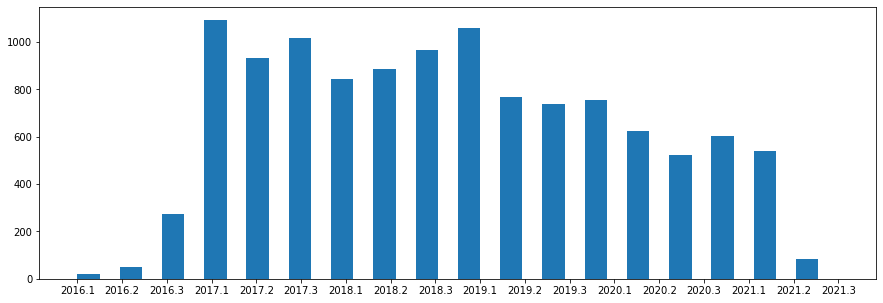

In [11]:
plt.figure(figsize=(15, 5))
plt.hist(versions, bins=len(unique_version), width=0.5);

In [12]:
summary_text = res_data.summary.apply(preprocess_text)
description_text = res_data.description.apply(preprocess_text)

In [13]:
res_text = summary_text + description_text

# Подбор параметров

In [32]:
num_topics_array = range(1, 300, 10)
summary_my_coherence_array = my_coherence(summary_text, num_topics_array)
description_my_coherence_array = my_coherence(description_text, num_topics_array)
res_my_coherence_array = my_coherence(res_text, num_topics_array)

100%|███████████████████████████████████████████| 30/30 [01:14<00:00,  2.49s/it]


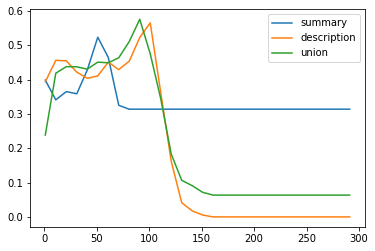

In [33]:
plt.plot(num_topics_array, summary_my_coherence_array, label='summary')
plt.plot(num_topics_array, description_my_coherence_array, label='description')
plt.plot(num_topics_array, res_my_coherence_array, label='union')
plt.legend()

In [38]:
# summary выглядит самым адеквантным, поэтому берем его
num_topics_array[np.argmax(summary_my_coherence_array)]

51

In [24]:
# воспользуемся встроенными методами, дольше работают и показывают что-то сранное
num_topics_array = range(1, 300, 10)
summary_coherence_array = coherence(summary_text, num_topics_array)
description_coherence_array = coherence(description_text, num_topics_array)
res_coherence_array = coherence(res_text, num_topics_array)

100%|███████████████████████████████████████████| 30/30 [06:28<00:00, 12.95s/it]


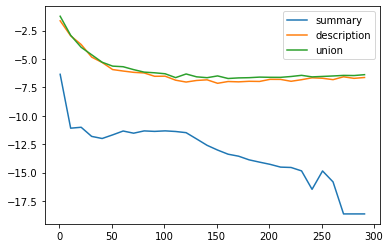

In [25]:
plt.plot(num_topics_array, summary_coherence_array, label='summary')
plt.plot(num_topics_array, description_coherence_array, label='description')
plt.plot(num_topics_array, res_coherence_array, label='union')
plt.legend()

# Итоговая модель

In [28]:
model = Lda(summary_text, 50)

In [29]:
# посмотрем на топ 10 слов в каждом топике
model.get_top_k_words_of_topics()

Topic: 0 
Words: ['plugin', 'support', 'quick', 'get', 'idea', 'error', 'intellij', 'import', 'member', 'suggests']
Topic: 1 
Words: ['variable', 'root', 'nest', 'displayed', 'base', 'name', '2', 'jupyter', 'environment', 'result']
Topic: 2 
Words: ['debugger', 'folder', 'remote', 'start', 'longer', 'script', 'connection', 'host', 'fail', 'path']
Topic: 3 
Words: ['reference', 'find', 'invalid', 'create', "'s", 'selection', 'git', 'template', 'detect', 'character']
Topic: 4 
Words: ['broken', 'whitespace', 'tag', 'inside', 'pep', 'match', 'comment', 'terminal', 'bracket', 'format']
Topic: 5 
Words: ['str', 'format', 'checker', 'requirement', 'ability', 'add', 'expect', 'unexpected', 'long', 'warn']
Topic: 6 
Words: ['wsl', 'load', 'configuration', 'dict', 'deployment', 'ssh', 'debug', 'value', 'take', 'correctly']
Topic: 7 
Words: ['save', 'sciview', 'cursor', 'seem', 'dunder', 'plot', 'execute', 'list', 'library', 'false']
Topic: 8 
Words: ['freeze', 'toolbar', 'ignore', 'overload', '

In [17]:
# красивая графическая визуализация
model.topics_visualization()

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
36     0.000151  0.398561       1        1  2.989048
10     0.398536  0.133476       2        1  2.965256
3     -0.198191  0.394919       3        1  2.766658
45    -0.110255  0.360869       4        1  2.753843
17     0.385003 -0.070494       5        1  2.635390
44     0.441392  0.023058       6        1  2.586760
24     0.104867  0.427518       7        1  2.577119
27    -0.366062 -0.241031       8        1  2.542736
49    -0.403717  0.173123       9        1  2.515353
15     0.252334  0.347453      10        1  2.507679
9      0.306052  0.210736      11        1  2.457981
29    -0.050491  0.283144      12        1  2.357431
33    -0.410200  0.085895      13        1  2.348162
40    -0.233650  0.285375      14        1  2.346022
38     0.322201  0.151778      15        1  2.321617
5     -0.303316  0.223119      16        1  2.290223
20     0.073497  0.177705      17        1  2.236331
16    -0.246572  0.027086      18        1  2.227663
37     0.208589  0.284565      19        1  2.200077
1      0.155779  0.158363      20        1  2.182244
12    -0.245764  0.148612      21        1  2.171044
2      0.108702 -0.368753      22        1  2.160885
13     0.083171  0.287468      23        1  2.138853
23    -0.130513 -0.288484      24        1  2.136013
47    -0.287475 -0.239353      25        1  2.093399
7      0.250341  0.039102      26        1  2.053205
18     0.346377 -0.239375      27        1  2.050942
30    -0.357204 -0.100109      28        1  1.968229
42     0.344780 -0.147261      29        1  1.964041
21    -0.135032 -0.399683      30        1  1.881187
48    -0.211128 -0.281870      31        1  1.831155
0      0.013045 -0.382707      32        1  1.739397
46    -0.391457 -0.020312      33        1  1.716349
4      0.148457 -0.240325      34        1  1.668314
31     0.238270 -0.274308      35        1  1.662532
14     0.149150 -0.106042      36        1  1.633032
32     0.244502 -0.052395      37        1  1.622961
6      0.209612 -0.359530      38        1  1.582710
28    -0.181409 -0.131652      39        1  1.568581
22    -0.046303 -0.219625      40        1  1.557262
8     -0.270779 -0.092592      41        1  1.551343
11    -0.056718  0.000617      42        1  1.549215
25     0.064794 -0.173175      43        1  1.480193
35    -0.037623 -0.350401      44        1  1.410710
41     0.025598  0.041281      45        1  1.332862
39    -0.121109  0.224482      46        1  1.271956
19    -0.100797  0.067328      47        1  1.269822
43    -0.071042 -0.074937      48        1  1.245643
26     0.009621 -0.068319      49        1  0.990391
34     0.081985 -0.032900      50        1  0.890183, topic_info=           Term       Freq      Total Category  logprob  loglift
222         wsl  29.000000  29.000000  Default  30.0000  30.0000
231   incorrect  41.000000  41.000000  Default  29.0000  29.0000
4        import  54.000000  54.000000  Default  28.0000  28.0000
282    debugger  34.000000  34.000000  Default  27.0000  27.0000
530        3.10  25.000000  25.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
4        import   0.028345  54.119718  Topic50  -7.2642  -2.8330
5       library   0.028345   8.233512  Topic50  -7.2642  -0.9500
7          root   0.028345  22.939078  Topic50  -7.2642  -1.9746
8    virtualenv   0.028345   1.420064  Topic50  -7.2642   0.8075
9        action   0.028345   8.926589  Topic50  -7.2642  -1.0308

[1876 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
279       3  0.793790        's
199      28  0.172578       ...
199      37  0.604025       ...
536      44  0.910689        10
332      20  0.631369         2
...     ...       ...       ...
111      16  0.512150   wrongly
222      38  0.953801       wsl
547      25  0.823014  wslbased
152       1  0.293876         x

## Выводы

Проблемы с импортами

Проблемы с версиями питона

Проблемы с удаленным доступом

Проблемы с code completion 

Прооблемы с путями

Проблемы с docker

Проблемы с jupyter

...

# Сравнение

In [30]:
mask = res_data['Affected versions'].apply(lambda x: '2020.2' in x)
summary_text_2020_2 = summary_text[mask]

mask = res_data['Affected versions'].apply(lambda x: '2020.3' in x)
summary_text_2020_3 = summary_text[mask]

In [31]:
prediction_2020_2 = model.predict(summary_text_2020_2)
prediction_2020_3 = model.predict(summary_text_2020_3)

In [32]:
model.predict_topics_visualization(summary_text_2020_2)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.050706 -0.397585       1        1  3.924905
10     0.224657  0.354525       2        1  3.744025
3     -0.431108  0.007806       3        1  3.671563
37     0.120209  0.362460       4        1  3.550965
30    -0.244962  0.261715       5        1  3.358083
44    -0.112211  0.433418       6        1  3.342852
17     0.254519 -0.312866       7        1  3.265386
12     0.235733 -0.192751       8        1  3.082524
13     0.311545  0.126573       9        1  2.765189
42     0.340966  0.203742      10        1  2.692413
47     0.362142  0.026506      11        1  2.586569
22     0.182934  0.184079      12        1  2.585950
36    -0.384119 -0.115679      13        1  2.536794
27    -0.368808 -0.205706      14        1  2.404708
45    -0.168643 -0.341913      15        1  2.399205
35     0.029452 -0.254859      16        1  2.376583
16    -0.170873 -0.106574      17        1  2.348733
29    -0.205757  0.191273      18        1  2.226175
20     0.036967  0.290627      19        1  2.200317
38     0.207671 -0.362892      20        1  2.197833
7      0.286868 -0.108416      21        1  2.159767
41    -0.017827  0.079772      22        1  2.035393
14     0.089459  0.099255      23        1  1.874305
11    -0.037842  0.022495      24        1  1.852604
15     0.028065  0.421841      25        1  1.790879
40    -0.337083  0.066752      26        1  1.786680
1     -0.231784  0.057023      27        1  1.781514
19    -0.106207  0.119919      28        1  1.769888
4      0.228756  0.042542      29        1  1.763194
49    -0.260788 -0.357922      30        1  1.737014
25     0.150257 -0.040837      31        1  1.698608
32     0.091508  0.227973      32        1  1.669617
18     0.302029  0.285886      33        1  1.614026
48    -0.280843 -0.076324      34        1  1.403147
9      0.124332 -0.342211      35        1  1.394831
23    -0.072633 -0.278713      36        1  1.336100
34    -0.061806 -0.045186      37        1  1.235499
46     0.338751 -0.221810      38        1  1.222199
6     -0.159105  0.353008      39        1  1.198104
39     0.047487 -0.369855      40        1  1.194708
24    -0.415661  0.134782      41        1  1.182251
0     -0.274743 -0.248504      42        1  1.130278
21     0.423352  0.026315      43        1  1.120253
2     -0.082637  0.307641      44        1  1.117935
28     0.114513 -0.174599      45        1  1.066681
43     0.020980 -0.081076      46        1  1.008480
33    -0.338358  0.248196      47        1  0.942154
31     0.370537 -0.085498      48        1  0.941255
8     -0.166643 -0.203341      49        1  0.871894
26     0.057458 -0.011006      50        1  0.839970, topic_info=            Term      Freq     Total Category  logprob  loglift
231    incorrect  8.000000  8.000000  Default  30.0000  30.0000
438          ssh  8.000000  8.000000  Default  29.0000  29.0000
222          wsl  5.000000  5.000000  Default  28.0000  28.0000
4         import  8.000000  8.000000  Default  27.0000  27.0000
46    completion  7.000000  7.000000  Default  26.0000  26.0000
..           ...       ...       ...      ...      ...      ...
12          show  0.007085  8.970717  Topic50  -7.0958  -2.3642
13        detect  0.007085  1.623068  Topic50  -7.0958  -0.6545
14   requirement  0.007085  2.046660  Topic50  -7.0958  -0.8864
15      function  0.007085  8.741263  Topic50  -7.0958  -2.3383
16        method  0.007085  5.099935  Topic50  -7.0958  -1.7995

[1862 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
279       3  0.806284        's
199       5  0.335616       ...
199      32  0.671232       ...
536      16  0.847472        10
332      27  0.800718         2
...     ...       ...       ...
156      19  0.289545     wrong
111       1  0.819636   wrongly
222      39  0.982947       wsl
547      11  1.022108  wslbased
152      32

In [33]:
model.predict_topics_visualization(summary_text_2020_3)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
45     0.121370 -0.369588       1        1  3.981131
5      0.278175  0.278977       2        1  3.788440
30    -0.321257 -0.043814       3        1  3.656446
37    -0.049521  0.386772       4        1  3.349099
7     -0.221373  0.138968       5        1  3.275790
10     0.214917  0.366744       6        1  3.143332
3      0.320627 -0.311223       7        1  3.121721
12     0.259724 -0.217993       8        1  3.117638
17     0.385585  0.114615       9        1  2.988779
11     0.022377 -0.020862      10        1  2.955715
36     0.402363  0.031060      11        1  2.753547
48     0.236593  0.150352      12        1  2.701546
47    -0.358082  0.031531      13        1  2.511892
19    -0.151574 -0.026573      14        1  2.468846
38     0.046100 -0.412597      15        1  2.336472
1     -0.072578 -0.221825      16        1  2.303067
16    -0.170623 -0.213615      17        1  2.232867
27     0.099951  0.415215      18        1  2.202997
13     0.016095  0.318984      19        1  2.132317
40     0.208890 -0.310013      20        1  2.120691
42     0.382707 -0.065820      21        1  2.106806
15    -0.175692  0.393579      22        1  2.089957
14     0.140814  0.011022      23        1  2.083234
44    -0.336409  0.293889      24        1  1.945419
35     0.148721  0.275971      25        1  1.882580
21    -0.323050  0.192582      26        1  1.845667
49    -0.436913 -0.072188      27        1  1.819595
33    -0.408177  0.118238      28        1  1.756230
41     0.004345 -0.087916      29        1  1.698482
20     0.015743 -0.308746      30        1  1.666225
4      0.251080  0.026775      31        1  1.604342
32     0.121699  0.181085      32        1  1.601171
46     0.336380  0.196305      33        1  1.594352
29    -0.257146 -0.127383      34        1  1.584565
22     0.079643 -0.206977      35        1  1.494783
26    -0.037021 -0.014208      36        1  1.418909
24    -0.268410 -0.353169      37        1  1.270348
18     0.384797 -0.164268      38        1  1.269122
39    -0.127280  0.296361      39        1  1.231510
9     -0.065424 -0.369753      40        1  1.183218
34    -0.036906  0.089350      41        1  1.129534
0     -0.288506 -0.232125      42        1  1.124689
43     0.055335  0.055428      43        1  1.105982
23     0.002101  0.237482      44        1  1.029963
28     0.143671 -0.143859      45        1  1.025209
6     -0.154002 -0.364071      46        1  0.946849
31    -0.201230  0.259682      47        1  0.837232
8      0.268634 -0.111949      48        1  0.837232
2     -0.345624 -0.157246      49        1  0.837232
25    -0.141639  0.066813      50        1  0.837232, topic_info=           Term      Freq     Total Category  logprob  loglift
231   incorrect  6.000000  6.000000  Default  30.0000  30.0000
438         ssh  5.000000  5.000000  Default  29.0000  29.0000
4        import  7.000000  7.000000  Default  28.0000  28.0000
482        save  5.000000  5.000000  Default  27.0000  27.0000
46   completion  5.000000  5.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
146        test  0.027825  2.971478  Topic50  -5.4661   0.1120
315        view  0.022261  2.521637  Topic50  -5.6892   0.0530
179   parameter  0.032814  7.139047  Topic50  -5.3011  -0.5996
36         name  0.024130  4.507908  Topic50  -5.6086  -0.4473
4        import  0.021859  7.807677  Topic50  -5.7074  -1.0954

[1867 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
279       7  0.599306        's
199       3  0.438719       ...
199      32  0.438719       ...
536      25  0.902083        10
332      16  0.851370         2
...     ...       ...       ...
156      30  0.453219     wrong
111       2  1.087207   wrongly
222      46  0.931366       wsl
547      13  0.676133  wslbased
152      32  0.874112  

In [35]:
unique_2020_2 = set(np.unique(prediction_2020_2))
unique_2020_3 = set(np.unique(prediction_2020_3))
                   
print(unique_2020_2 - unique_2020_3)
print(unique_2020_3 - unique_2020_2)

{2, 8, 9, 23, 25, 31}
{33}


In [36]:
all_topics = set(np.arange(50))
add_topics_2 = list(all_topics - unique_2020_2)
prediction_2020_2 = np.append(prediction_2020_2, add_topics_2)

add_topics_3 = list(all_topics - unique_2020_3)
prediction_2020_3 = np.append(prediction_2020_3, add_topics_3)

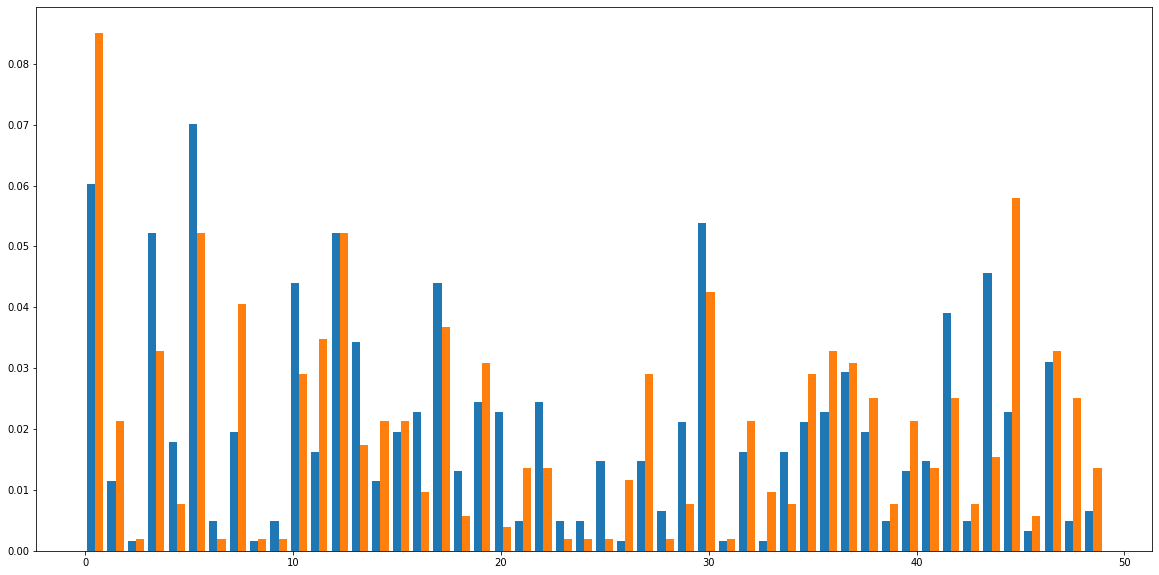

In [37]:
plt.figure(figsize=(20, 10))
plt.hist([prediction_2020_2, prediction_2020_3], bins=50, density=True);

In [38]:
for t in unique_2020_2 - unique_2020_3:
    topic_top_k_words = model.get_top_k_words_of_topic(t, 20)
    print(f"Topic: {t} \nWords: {topic_top_k_words}")

Topic: 2 
Words: ['debugger', 'folder', 'remote', 'start', 'longer', 'script', 'connection', 'host', 'fail', 'path', 'warn', 'move', 'module', 'set', 'call', 'dialog', 'take', 'download', '2021.1', '2020.3']
Topic: 8 
Words: ['freeze', 'toolbar', 'ignore', 'overload', 'parameter', 'unpack', 'current', 'console', 'whole', 'negative', 'right', 'creation', 'folder', 'ide', 'new', 'false', 'rename', 'name', 'action', 'complete']
Topic: 9 
Words: ['call', 'venv', 'argument', 'debug', 'treat', 'change', 'crash', 'object', 'block', 'first', 'different', 'incorrect', 'method', 'function', 'mode', 'return', 'hint', 'create', 'wrong', 'move']
Topic: 23 
Words: ['report', 'service', 'function', 'window', 'dockercompose', 'version', 'app', 'pass', 'one', 'specify', 'error', 'preview', 'link', 'output', 'configuration', 'notebook', 'compose', 'jupyter', 'create', 'decorate']
Topic: 25 
Words: ['statement', 'docstring', 'recognize', 'restart', 'wrong', 'fail', 'parameter', 'new', 'evaluate', 'found'

In [39]:
for t in unique_2020_3 - unique_2020_2:
    topic_top_k_words = model.get_top_k_words_of_topic(t, 20)
    print(f"Topic: {t} \nWords: {topic_top_k_words}")

Topic: 33 
Words: ['import', 'show', 'click', 'eap', 'requirements.txt', 'add', 'package', 'name', 'breakpoint', 'exception', 'multiline', 'menu', 'context', 'ignore', 'see', 'view', 'error', 'test', 'another', 'directory']


## Выводы

Видно, что при переходе от 2020.2 к 2020.3 было полностью решено шесть топика, но добавлен один новый.

Починили проблемы с дебагером на удаленной машине, проблемы с лагами, ...

Появились проблемы с пакетами при импортировании или добавлении их в requirements.txt

Также изменились соотношения в других топиках